### In this notebook, we are exploring an A/B test by a software company. This company usually sells its software for $\$39$, and decided to test a price of $\$59$ with 33% of its users.

To solve this problem we first approached the overall problem by looking for per-user profit and conversion rates. There was a clear (and statistically significant) advantage to the test ($\$59$) group: $\$0.92$ vs $\$0.78$. This advantage was in spite of a modest drop in the conversion rate. 

We downsampled the control ($\$39$) group, and looked at some distributions to make sure that the test was done randomly. We then proceeded to carefully plot and study some subgroups to potentially identify segments of users that may break the overall pattern (by either showing a stronger favorability to the control or the test). 

We did not find extremely strong patterns in the plots, only modelately strong. 

We then created a function that calculates a Welch's T-Test for any segment of users. The function also prints conversion rates and profit-per-user. We found the strongest case for the test in users who were directed by google-ads ($\$1.16$ vs $\$0.88$, p-value of $10^{-5}$). The weakest case was in facebook-ads directed users.

In the end we commented that while the entire test could have been done in a time shorter by a few times, longer tests are favorable for studying segments of users and making more granular recommendations.

## 1. Data Loading
Load the data and profile using pandas_profiling:

In [1]:
import pandas as pd
tests = pd.read_csv("test_results.csv")
users = pd.read_csv("user_table.csv")

In [5]:
import pandas_profiling
pandas_profiling.ProfileReport(test)

Number of variables,8
Number of observations,316800
Total Missing (%),0.0%
Total size in memory,19.3 MiB
Average record size in memory,64.0 B
Numeric,1
Categorical,4
Boolean,2
Date,0
Text (Unique),0
Rejected,1


In [6]:
pandas_profiling.ProfileReport(users)

Number of variables,5
Number of observations,275616
Total Missing (%),0.0%
Total size in memory,10.5 MiB
Average record size in memory,40.0 B
Numeric,3
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,1


## 2. Overall results and significance 
First take a look at the conversion rate and then discuss the result:

In [2]:
test[['test', 'converted']].groupby('test').sum()

,converted
test,
0,4035
1,1773


In [3]:
test[['test', 'converted']].groupby('test').count()

,converted
test,
0,202727
1,114073


### We can now calculate the expected profit per viewer or user: 

Profit per user in test case: 1773/114073 * \$59 = **\$0.92**/user

With regular pricing: 4035/202727 * \$39 = **\$0.78**/user

So presumably we are more profitable in the test case, but what is the confidence level? We can design a binomial-like test for this situation to get a p-value. (A Welch's t-test might sort of work as well).

It is likely an elaborate test is not needed, because we can estimate the error bar for both conversion rates, which are binomially distributed, and see that the confidence is high. The conversion rate is also approximately poisson distributed given how small the probabilities are. 

#### The stanard errors are apprx. given by square root (poisson errors):
For $4035 \pm 64 = 4035 \pm 1.6\%$

And: $1773 \pm 42 = 4035 \pm 2.4\%$

**Given that the difference between 92 cents and 78 cents is more than 10\%, this is clearly a significant result.**

Note that the binomial correction to the poisson error is small (it has a 1-p term, which is a 1% correction).

## 3. User Segments

At this point we note that it is still important to understand user behvior more granularly, so that we can tailor our approach to every user. Perhaps some users would still better be shown the lower price? 

\$0.92/user is the number to beat with an overall strategy.

In [2]:
#let's first see that the test isn't biased
testGroup = tests[tests['test']==1]
controlGroup = tests[tests['test']==0]

controlGroup_downsampled = controlGroup.sample(frac=114073/202727)
testsBalanced = pd.concat([testGroup, controlGroup_downsampled])

Populating the interactive namespace from numpy and matplotlib


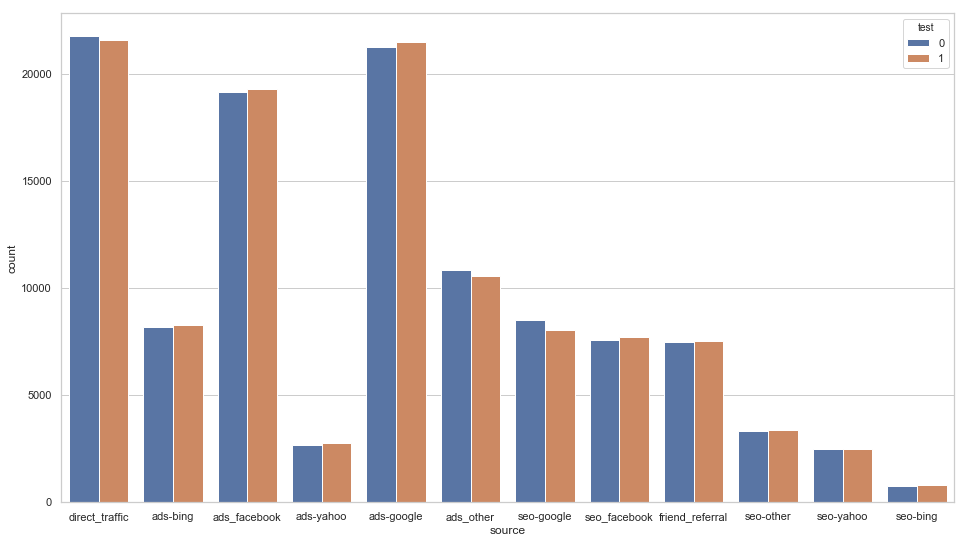

In [11]:
#let's check that the distributions of source are the same (and have been properly randomized)
%pylab inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]

import seaborn as sns
sns.set(style="whitegrid")
ax = sns.countplot(x='source',data=testsBalanced, hue='test')

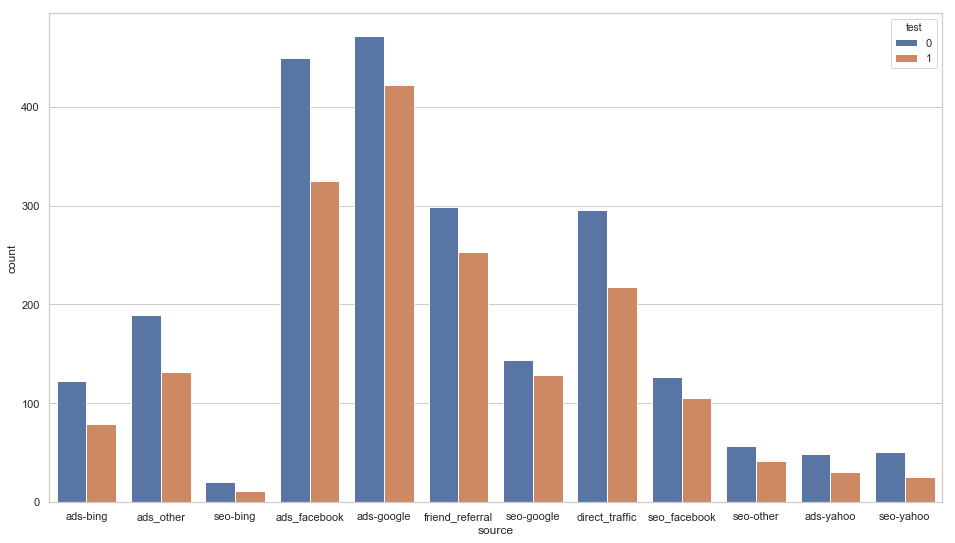

In [28]:
ax = sns.countplot(x='source',data=testsBalanced[testsBalanced['converted']==1], hue='test')

Using the plot above we can get an idea for which of our users are more sensitive to the higher price. Clearly, google users are not highly impacted, but facebook users are!

Let's make a similar plot for:
1) Device.
2) Operative system.
3) City of user. (for this we will need to join the dataframes).

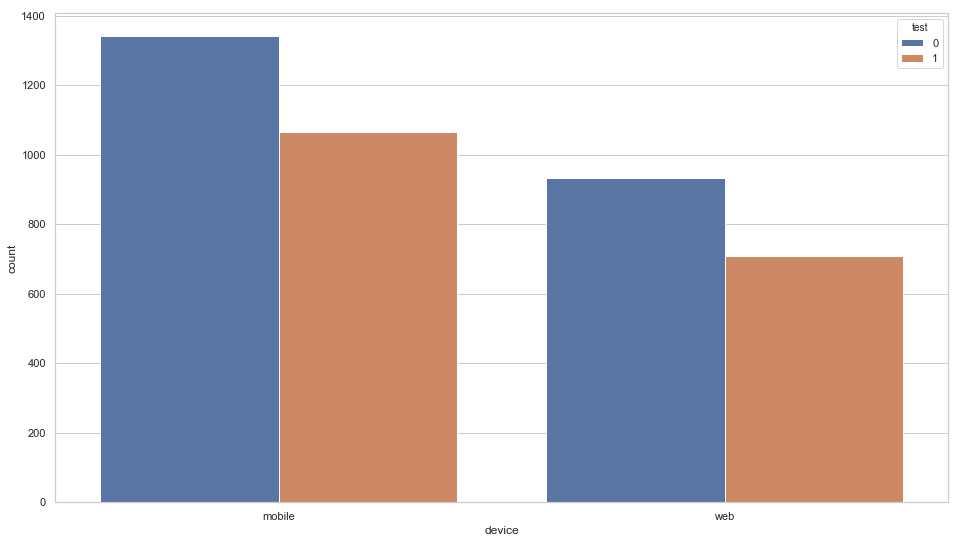

In [29]:
ax = sns.countplot(x='device',data=testsBalanced[testsBalanced['converted']==1], hue='test')

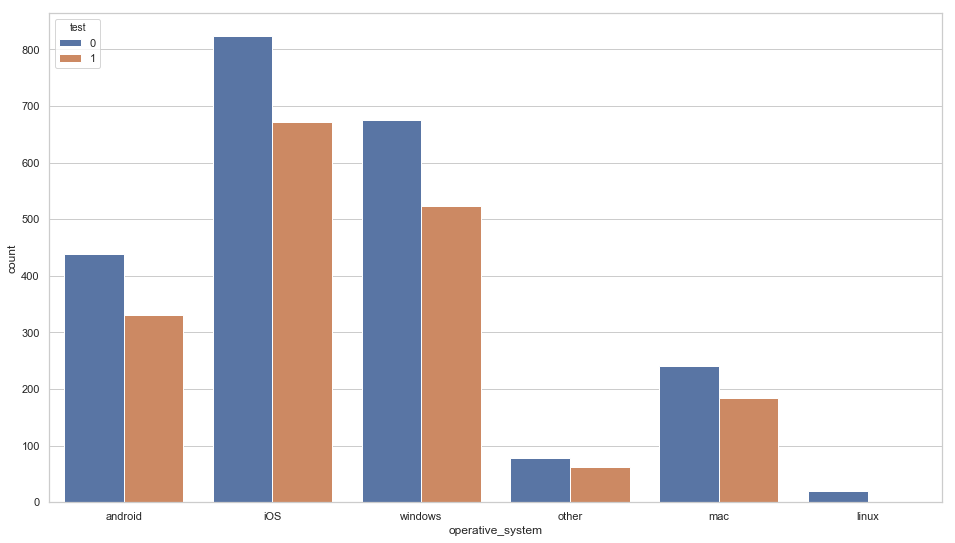

In [30]:
ax = sns.countplot(x='operative_system',data=testsBalanced[testsBalanced['converted']==1], hue='test')

In [23]:
#merge city into both the balanced and original test DF
testsBalanced = pd.merge(testsBalanced, users[['user_id', 'city']], how='left', on='user_id', sort=False)
tests = pd.merge(tests, users[['user_id', 'city']], how='left', on='user_id', sort=False)

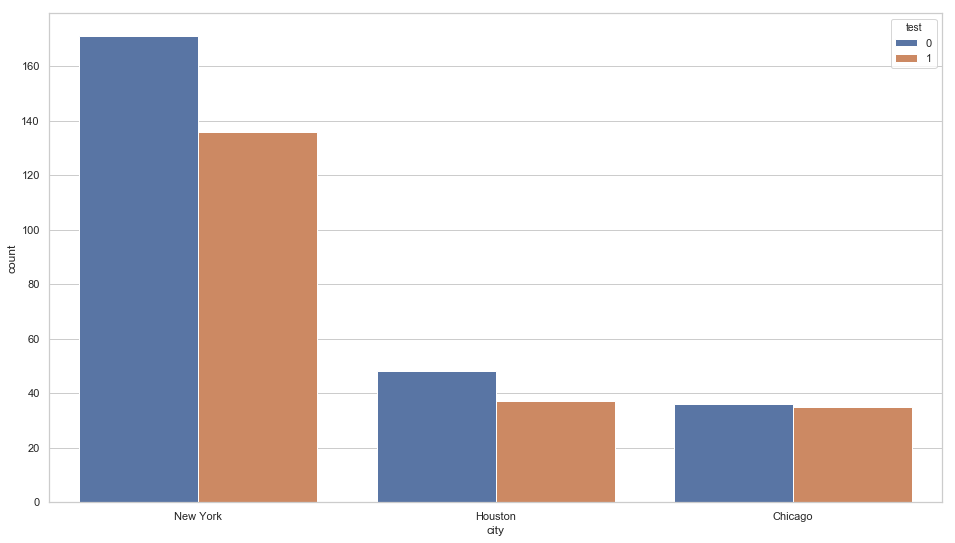

In [18]:
ax = sns.countplot(x='city', data=testsBalanced.query
                   ('converted == 1 and (city == "New York" or city == "Chicago" or city == "Houston")'), hue='test')

## 4. Using the T-Test to study segments

In [33]:
#We can now dessign a t-test function that will perform a t-test for a given feautre=value
from scipy.stats import ttest_ind
def testPrediction(dataframe, testFeature, testValue):
    testDF = dataframe[dataframe[testFeature] == testValue]
    DFControl = testDF[testDF['test'] == 0]
    DFTest = testDF[testDF['test'] == 1]
    
    controlVec = DFControl["converted"].values * 39
    testVec = DFTest["converted"].values * 59
    print("Conversion Rate for Control is: " + str(sum(controlVec==39)/len(controlVec)))
    print("Conversion Rate for Test is: " + str(sum(testVec==59)/len(testVec)))
    
    print("Profit per user for Control is: " + str(sum(controlVec)/len(controlVec)))
    print("Profit per user for Test is: " + str(sum(testVec)/len(testVec)))
    
    return ttest_ind(controlVec, testVec, axis=0, equal_var=False)

In [34]:
testPrediction(tests, 'city', 'New York')

Conversion Rate for Control is: 0.018525223268163166
Conversion Rate for Test is: 0.014821272885789015
Profit per user for Control is: 0.7224837074583635
Profit per user for Test is: 0.8744551002615518


Ttest_indResult(statistic=-1.7899154458078927, pvalue=0.07348795219423211)

In [35]:
testPrediction(tests, 'source', 'ads-google')

Conversion Rate for Control is: 0.02255440523980562
Conversion Rate for Test is: 0.019614222635370673
Profit per user for Control is: 0.8796218043524192
Profit per user for Test is: 1.1572391354868696


Ttest_indResult(statistic=-4.391181018526578, pvalue=1.1307720355505545e-05)

Above we found a very strong case, with profit per user of \$1.16, and a very clear p-value. **Google_Ads are a very strong result**

In [37]:
testPrediction(tests, 'source', 'ads_facebook')

Conversion Rate for Control is: 0.023666383178392328
Conversion Rate for Test is: 0.016841996165207027
Profit per user for Control is: 0.9229889439573008
Profit per user for Test is: 0.9936777737472146


Ttest_indResult(statistic=-1.115206873371614, pvalue=0.2647699755237486)

In [38]:
testPrediction(tests, 'device', 'mobile')

Conversion Rate for Control is: 0.019878653065628606
Conversion Rate for Test is: 0.016138808910440977
Profit per user for Control is: 0.7752674695595156
Profit per user for Test is: 0.9521897257160176


Ttest_indResult(statistic=-5.37469314122894, pvalue=7.687548131254738e-08)

In [39]:
testPrediction(tests, 'source', 'direct_traffic')

Conversion Rate for Control is: 0.013545241105291674
Conversion Rate for Test is: 0.010093527178442448
Profit per user for Control is: 0.5282644031063753
Profit per user for Test is: 0.5955181035281044


Ttest_indResult(statistic=-1.4555801408381333, pvalue=0.14551748161479516)

#### We haven't been able to find a case where the test group did better. 

#### We will also note that the power of a t-test (or anything similar) is roughly sqrt(n) for a given mean difference, thus at most we would have been able to shorten the test by a few times (and still get the overall positive result). Especially for segmentation, longer timing is very helpful, and in this form of exploration we are not done yet.


## 5. Summary:

1) We have been able to show that the result for the test is significantly positive ($0.92 - 0.78$ / user).

2) After exploring user segments, we did not identify clear cases where this is likely to be reversed. We did see some moderate variation.

3) We designed a function that provides a p-value using Welch's T-Test for any user segment. The segments we explored all showed favorability for the higher price point. The functionality we impltemented will allow one to do further exploration in this regard.


